# Description

Goal - The main aim of this project is to identify whether question pairs in the dataset have the same content or not. The goal is to predict which of the provided pairs of questions contain two questions with the same meaning.

This project is divided into three major parts:
1. Data Analysis and Visualizations
2. Developing Logistic Regression Model
3. Developing LSTM Neural Network model

### Logistic Regression Model:
Steps:
1. Data Preprocessing - Transform features by scaling each feature 
2. Using GridSearchCV, we do Exhaustive search over specified parameter values for an estimator.
3. Train LR model using best parameters.
4. Visualize the results of CV parameters.

### LSTM Model:

Steps:
1. Data Preprocessing - Convert text to machine readable format
2. Prepare Embedding matrix using word index of text data in dataset with the help of word2vec for word Embeddings.
3. Define the Model using Embedding layers and LSTM layers.
4. Train and Learn the Model till ethical accuracy is attained.

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
%matplotlib inline

from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from nltk.stem import SnowballStemmer
from string import punctuation

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import os
import re
import csv
import codecs

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

#Import the necessaries libraries
import plotly.offline as py
import plotly.graph_objs as go
#Set notebook mode to work in offline
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Import Files

Initialize file paths for better searching in different systems.

In [ ]:
training_file_path = "/content/gdrive/My Drive/quora-question-pairs/train.csv"
testing_file_path = "/content/gdrive/My Drive/quora-question-pairs/test.csv"
embedding_file_path = "/content/gdrive/My Drive/quora-question-pairs/GoogleNews-vectors-negative300.bin"

In [ ]:
training_df = pd.read_csv(training_file_path).fillna("")
testing_df = pd.read_csv(testing_file_path).fillna("")

train_df = training_df.copy()
test_df = testing_df.copy()
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(2345796, 3)


# Data Visualization

##### Output Variable


Let's first look at the target variable distribution (i.e is_duplicate).


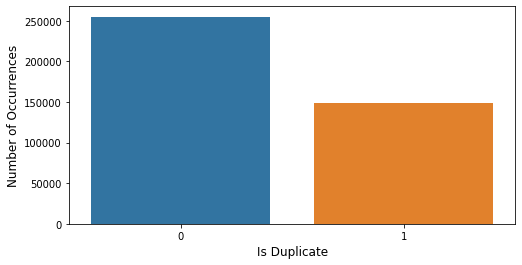

In [ ]:
target = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(target.index, target.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [ ]:
# Combine questions of question1 and question2 column to get all questions in training data

all_questions_training_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_questions_training_df.columns = ["questions"]


# Calculating number of words in each question set
all_questions_training_df["num_of_words"] = all_questions_training_df["questions"].apply(lambda x : len(str(x).split()))

In [ ]:
print(all_questions_training_df.shape)
all_questions_training_df.head()

(808580, 2)


,questions,num_of_words
0,What is the step by step guide to invest in share market in india?,14
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,8
2,How can I increase the speed of my internet connection while using a VPN?,14
3,Why am I mentally very lonely? How can I solve it?,11
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",13


##### Distribution of Number of Words per question

Bar Plot for number of questions having same "Number of Words" in each question.

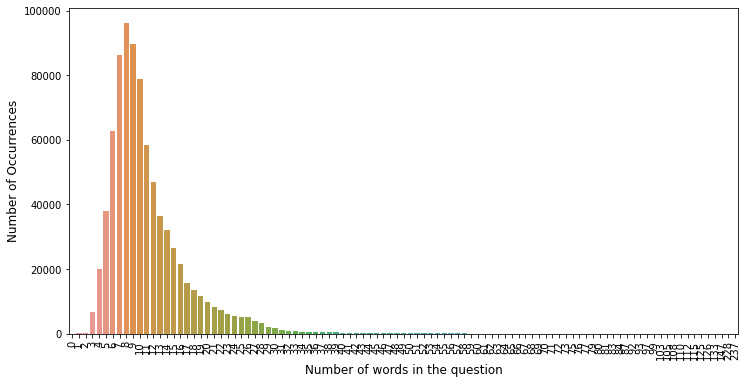

In [ ]:
count_number_of_words = all_questions_training_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_number_of_words.index, count_number_of_words.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So, the distribution is right skewed. There are very less number of questions having 1-3 words per question. The majority of questions have words from 7-13 words per question.

##### Distribution of Number of Characters per question

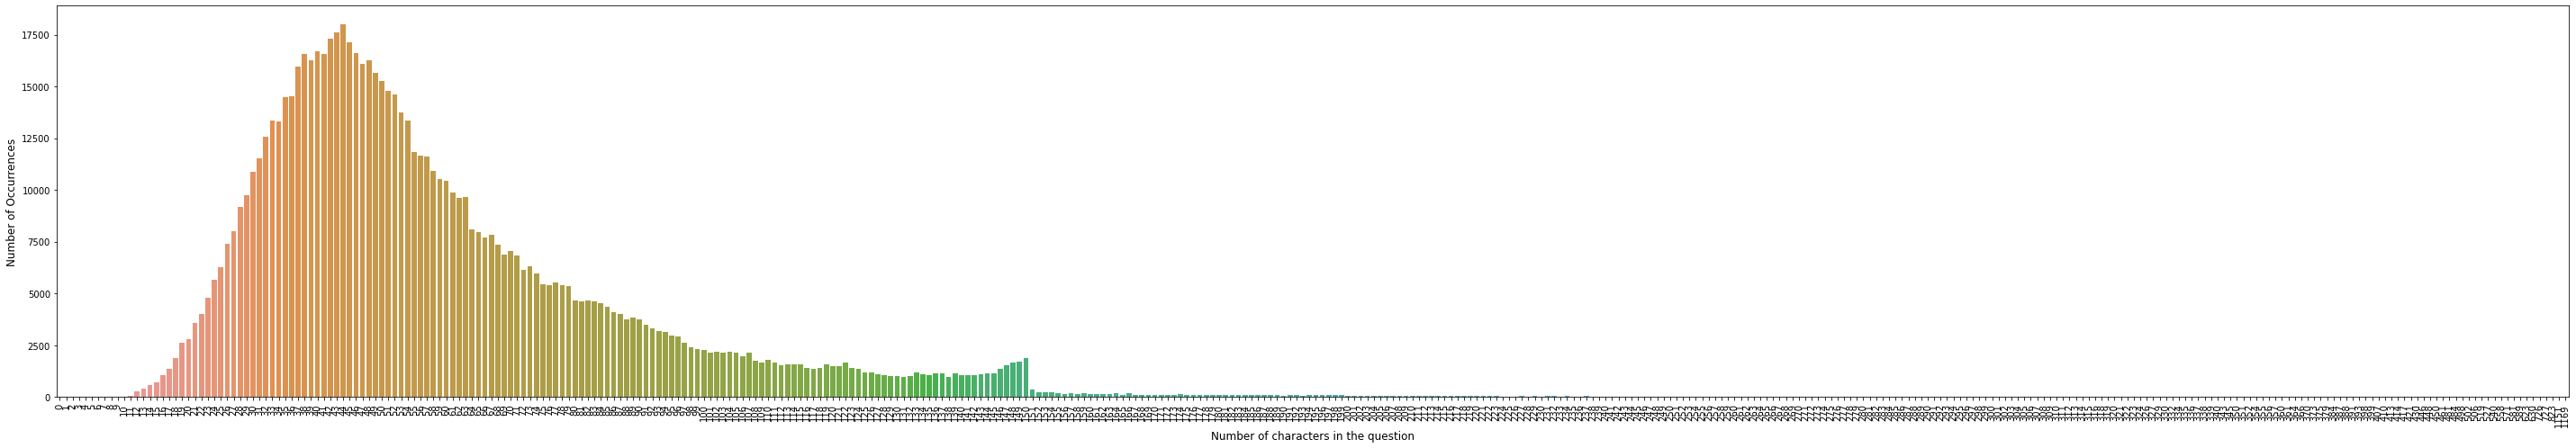

In [ ]:
all_questions_training_df["num_of_chars"] = all_questions_training_df["questions"].apply(lambda x : len(str(x)))
count_number_of_chars = all_questions_training_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(count_number_of_chars.index, count_number_of_chars.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_questions_training_df



So, It can be found that Number of characters distribution is also right skewed.


#### Distribution of common unigrams between the given question pairs.

In [ ]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

In [ ]:
%%time
train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

CPU times: user 1min 57s, sys: 292 ms, total: 1min 57s
Wall time: 1min 57s


In [ ]:
print(train_df.shape)
train_df.head()

(404290, 10)


,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,"[step, step, guide, invest, share, market, india, ?]","[step, step, guide, invest, share, market, ?]",6,0.857143
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, kohinoor, (, koh-i-noor, ), diamond, back, ?]",6,0.461538
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,"[increase, speed, internet, connection, using, vpn, ?]","[internet, speed, increased, hacking, dns, ?]",3,0.300000
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,"[mentally, lonely, ?, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [, /math, ], divided, 24,23, ?]",1,0.062500
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, ,, salt, ,, methane, carbon, di, oxide, ?]","[fish, would, survive, salt, water, ?]",3,0.200000


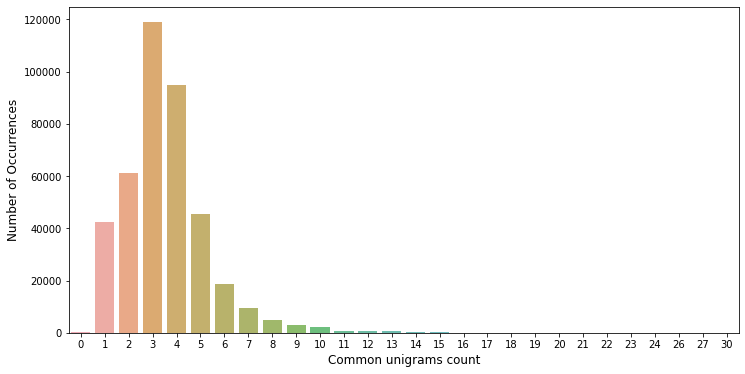

In [ ]:
count_common_unigrams = train_df['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_common_unigrams.index, count_common_unigrams.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

It is observed that most common frequenct of common unigrams is 3.

Let's plot 'common unigram count' for each type of output variable.

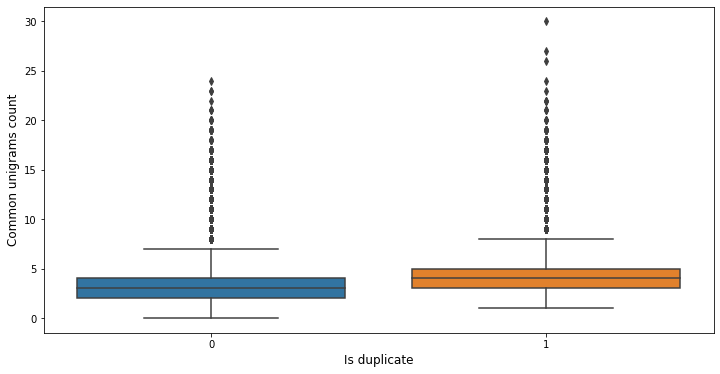

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_count", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()



There is some good difference between 0 and 1 class using the common unigram count variable. Let us look at the same graph using common unigrams ratio.


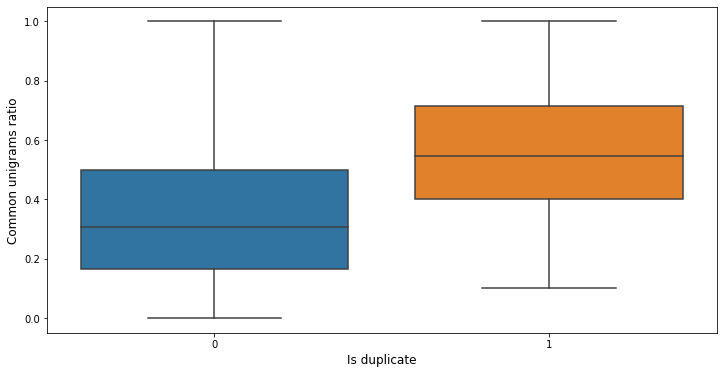

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_ratio", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams ratio', fontsize=12)
plt.show()

Within the box, a vertical line is at the Q2, the median of the data set. Two horizontal lines, called whiskers, extend from the front and back of the box. The front whisker goes from Q1 to the smallest non-outlier in the data set, and the back whisker goes from Q3 to the largest non-outlier.

#### Leaky Features Exploration:

Let's merge all the questions from both the datasets (i.e. Training and Testing)

In [ ]:
all_questions_df = pd.concat([train_df[['question1', 'question2']], \
        test_df[['question1', 'question2']]], \
        axis=0).reset_index(drop='index')

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(all_questions_df.shape)
all_questions_df.head()

(404290, 10)
(2345796, 3)
(2750086, 2)


,question1,question2
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?
3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?"
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?


In [ ]:
%%time
from collections import defaultdict

q_dict = defaultdict(set)
for i in range(all_questions_df.shape[0]):
        q_dict[all_questions_df.question1[i]].add(all_questions_df.question2[i])
        q_dict[all_questions_df.question2[i]].add(all_questions_df.question1[i])


CPU times: user 4min 27s, sys: 739 ms, total: 4min 28s
Wall time: 4min 28s


In [ ]:
#q_dict

Count of each questions in dictionary of questions

In [ ]:
def q1_freq(row):
    return(len(q_dict[row['question1']]))
    
def q2_freq(row):
    return(len(q_dict[row['question2']]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

In [ ]:
train_df['q1_q2_intersect'] = train_df.apply(q1_q2_intersect, axis=1, raw=True)
train_df['q1_freq'] = train_df.apply(q1_freq, axis=1, raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq, axis=1, raw=True)

In [ ]:
print(train_df.shape)
train_df.head()

(404290, 13)


,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,q1_q2_intersect,q1_freq,q2_freq
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,"[step, step, guide, invest, share, market, india, ?]","[step, step, guide, invest, share, market, ?]",6,0.857143,0,1,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, kohinoor, (, koh-i-noor, ), diamond, back, ?]",6,0.461538,0,8,3
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,"[increase, speed, internet, connection, using, vpn, ?]","[internet, speed, increased, hacking, dns, ?]",3,0.300000,0,2,1
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,"[mentally, lonely, ?, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [, /math, ], divided, 24,23, ?]",1,0.062500,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, ,, salt, ,, methane, carbon, di, oxide, ?]","[fish, would, survive, salt, water, ?]",3,0.200000,0,3,1




Q1-Q2 neighbor intersection count:

Let us first do simple count plots and see the distribution.


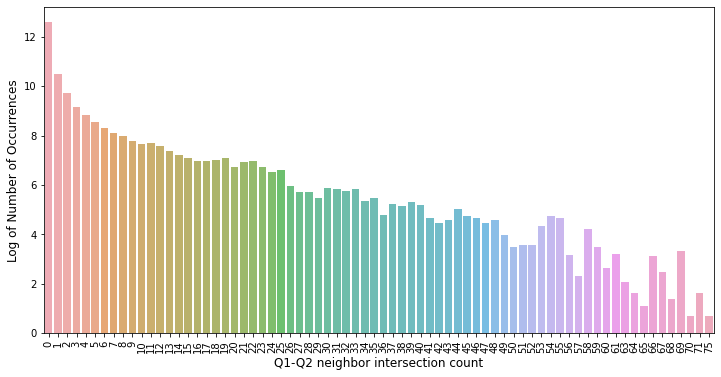

In [ ]:
count_q1_q2_intersect = train_df['q1_q2_intersect'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_q1_q2_intersect.index, np.log1p(count_q1_q2_intersect.values), alpha=0.8)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.ylabel('Log of Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

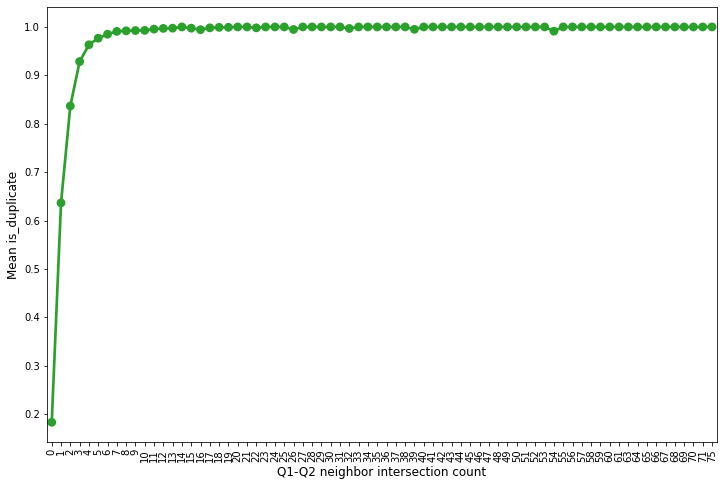

In [ ]:
grouped_df = train_df.groupby('q1_q2_intersect')['is_duplicate'].aggregate(np.mean).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df["q1_q2_intersect"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[2])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()



Wow. This explains why this variable is super predictive.!

# Feature EDA

In [ ]:
train_df = training_df.copy()

In [ ]:
print(train_df.shape)
train_df.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [ ]:
train_question_1_df, train_question_2_df = train_df[['qid1', 'question1']], train_df[['qid2', 'question2']]
train_question_2_df.columns = ['qid1', 'question']
train_question_2_df.columns = ['qid2', 'question']

In [ ]:
# merge the two dfs, there are two nans for question

train_question_all_df = pd.concat((train_question_1_df, train_question_2_df), axis=0).fillna("")
rows_of_q1 = train_question_all_df.shape[0]/2
train_question_all_df.shape

(808580, 4)

In [ ]:
rows_of_q1 = int(rows_of_q1)
rows_of_q1

404290

In [ ]:
train_question_all_df["question"][:rows_of_q1]

0          
1          
2          
3          
4          
         ..
404285     
404286     
404287     
404288     
404289     
Name: question, Length: 404290, dtype: object

In [ ]:
train_question_all_df["question"][rows_of_q1:]

0         What is the step by step guide to invest in share market?                                                                      
1         What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?                                       
2         How can Internet speed be increased by hacking through DNS?                                                                    
3         Find the remainder when [math]23^{24}[/math] is divided by 24,23?                                                              
4         Which fish would survive in salt water?                                                                                        
                           ...                                                                                                           
404285    How many keywords are there in PERL Programming Language in the latest version?                                                
404286    Is it true that there is

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

vectorizer = TfidfVectorizer(max_features = 256)

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 47.7 µs


In [ ]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=256,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
question_vctors = vectorizer.fit_transform(train_question_all_df['question'].values)

In [ ]:
question_vctors

<808580x256 sparse matrix of type '<class 'numpy.float64'>'
	with 2532804 stored elements in Compressed Sparse Row format>

In [ ]:
print(vectorizer.get_feature_names())

['10', '1000', '2016', '500', 'about', 'account', 'after', 'all', 'am', 'an', 'and', 'android', 'any', 'anyone', 'app', 'are', 'as', 'ask', 'at', 'back', 'bad', 'be', 'become', 'been', 'before', 'being', 'best', 'better', 'between', 'black', 'book', 'books', 'business', 'but', 'buy', 'by', 'can', 'car', 'card', 'change', 'china', 'clinton', 'college', 'com', 'companies', 'company', 'compare', 'computer', 'could', 'country', 'data', 'day', 'days', 'did', 'difference', 'different', 'do', 'does', 'doing', 'don', 'donald', 'during', 'earn', 'earth', 'energy', 'engineering', 'english', 'even', 'ever', 'exam', 'examples', 'facebook', 'feel', 'find', 'first', 'for', 'free', 'friend', 'friends', 'from', 'get', 'getting', 'girl', 'give', 'go', 'going', 'good', 'google', 'government', 'had', 'happen', 'has', 'have', 'he', 'help', 'her', 'high', 'hillary', 'him', 'his', 'home', 'how', 'if', 'important', 'improve', 'in', 'increase', 'india', 'indian', 'instagram', 'into', 'iphone', 'is', 'it', 'it

In [ ]:
diff_encodings = np.abs(question_vctors[:rows_of_q1] - question_vctors[rows_of_q1:])
diff_encodings

<404290x256 sparse matrix of type '<class 'numpy.float64'>'
	with 2532804 stored elements in Compressed Sparse Row format>

In [ ]:
diff_encodings.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.36447782]])

In [ ]:
# %%time
# from sklearn.manifold import TSNE
# tsne = TSNE(
#     n_components=3,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=260,
#     verbose=2,
#     angle=0.5
# ).fit_transform(diff_encodings.toarray())

In [ ]:
# %%time
# trace1 = go.Scatter3d(
#     x=tsne[:,0],
#     y=tsne[:,1],
#     z=tsne[:,2],
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         color = dfs['is_duplicate'].values,
#         colorscale = 'Portland',
#         colorbar = dict(title = 'duplicate'),
#         line=dict(color='rgb(255, 255, 255)'),
#         opacity=0.75
#     )
# )

# data=[trace1]
# layout=dict(height=800, width=800, title='test')
# fig=dict(data=data, layout=layout)
# py.iplot(fig, filename='3DBubble')


In [ ]:
train_df['q1len'] = train_df['question1'].str.len()
train_df['q2len'] = train_df['question2'].str.len()

In [ ]:
train_df['q1_n_words'] = train_df['question1'].apply(lambda row: len(row.split(" ")))
train_df['q2_n_words'] = train_df['question2'].apply(lambda row: len(row.split(" ")))

In [ ]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [ ]:
%%time
train_df['word_share'] = train_df.apply(normalized_word_share, axis=1)

CPU times: user 11.7 s, sys: 47.9 ms, total: 11.7 s
Wall time: 11.7 s


In [ ]:
print(train_df.shape)
train_df.head()

(404290, 11)


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,76,39,13,7,0.100000


Plotting graphs for output vs word_share values.

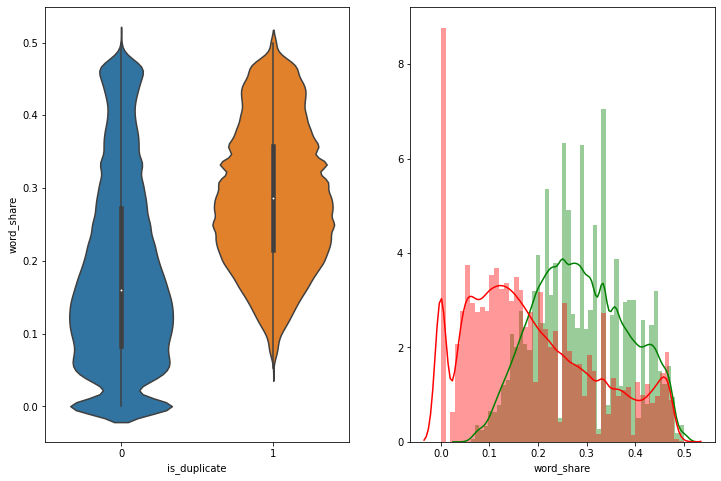

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train_df)

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['word_share'], color = 'green')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['word_share'], color = 'red')

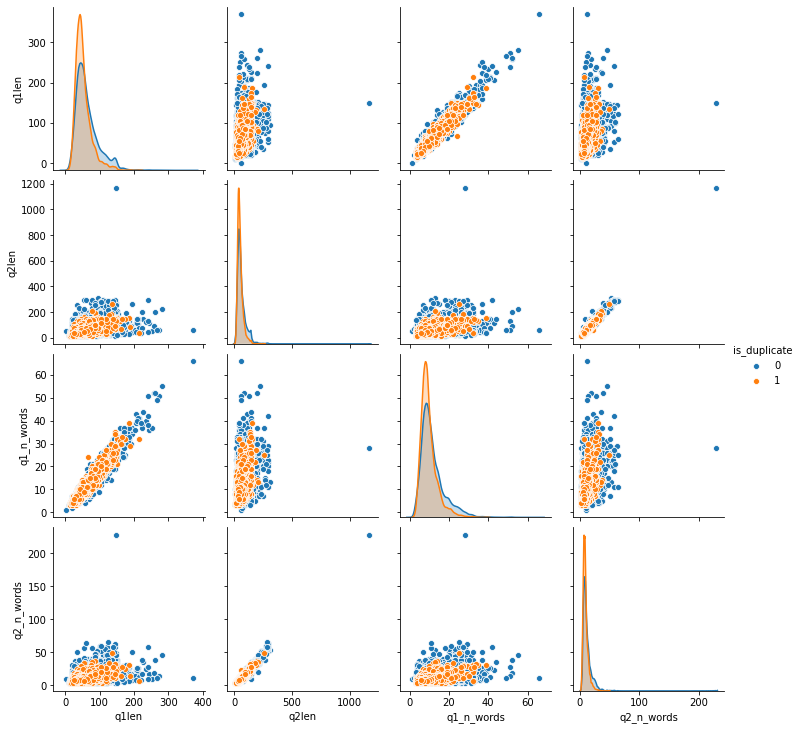

In [ ]:
n = 10000
sns.pairplot(train_df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

# Model 1 - Logistic Regression

#### Data Preprocessing

We will apply MinMaxScalar Estimator which will scale and translate each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [ ]:
scaler = MinMaxScaler().fit(train_df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

X = scaler.transform(train_df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = train_df['is_duplicate']

In [ ]:
X

array([[0.105939  , 0.04875962, 0.10483871, 0.04661017, 0.86956522],
       [0.08186196, 0.07527802, 0.05645161, 0.05084746, 0.4       ],
       [0.11717496, 0.05047049, 0.10483871, 0.03813559, 0.33333333],
       ...,
       [0.02728732, 0.01454234, 0.02419355, 0.00847458, 0.28571429],
       [0.15088283, 0.10863986, 0.12903226, 0.10169492, 0.05      ],
       [0.05939005, 0.03849444, 0.05645161, 0.03813559, 0.88888889]])

In [ ]:
y

0         0
1         0
2         0
3         0
4         0
         ..
404285    0
404286    1
404287    0
404288    0
404289    0
Name: is_duplicate, Length: 404290, dtype: int64

#### Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270874, 5), (133416, 5), (270874,), (133416,))

#### Define the Model

In [ ]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0], # Inverse of regularization strength
    'penalty': ['l1', 'l2'] # Used to specify the norm used in the penalization.
}

cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)

In [ ]:
cv

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

The parameters of the estimator used to apply fit method are optimized by cross-validated grid-search over a parameter grid.

#### Train the Model

In [ ]:
%%time
cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


CPU times: user 2.1 s, sys: 1.34 s, total: 3.44 s
Wall time: 9.26 s


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [ ]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

4. Mean validation neg log loss: nan (std: nan) - {'C': 1e-06, 'penalty': 'l1'}
3. Mean validation neg log loss: -0.658 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
5. Mean validation neg log loss: nan (std: nan) - {'C': 0.001, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.582 (std: 0.001) - {'C': 0.001, 'penalty': 'l2'}
6. Mean validation neg log loss: nan (std: nan) - {'C': 1.0, 'penalty': 'l1'}
1. Mean validation neg log loss: -0.568 (std: 0.002) - {'C': 1.0, 'penalty': 'l2'}


In [ ]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 1.0, 'penalty': 'l2'}
[[-10.24805964  -0.91757482   6.77261556  -7.16409458   3.29918187]]


For our Logistic Regression model, the best parameters for C is 1.0 and penalty is 'l2'.
Let's compare these parameters with other possibilites by drawing the Area under Curve graph.

C: 1e-06, parameters [[-0.0010675  -0.00061358 -0.00087867 -0.00056285  0.01291762]] and intercept [-0.54411749]
C: 0.0001, parameters [[-0.09281632 -0.05367061 -0.0756433  -0.04894879  0.91608226]] and intercept [-0.93486061]
C: 1.0, parameters [[-10.24805964  -0.91757482   6.77261556  -7.16409458   3.29918187]] and intercept [-1.34040782]


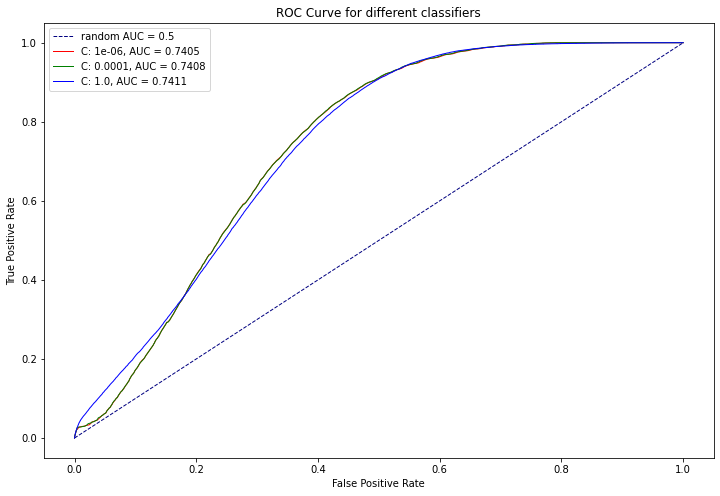

In [ ]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train, y_train)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

Text(0, 0.5, 'Precision')

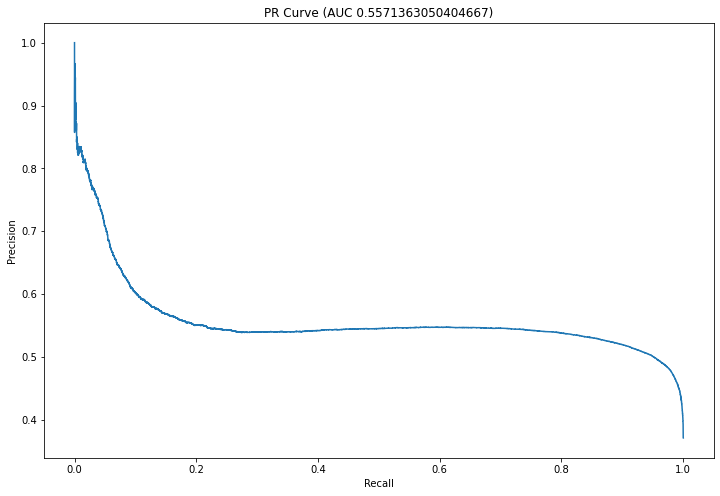

In [ ]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

#### Test the Model

In [ ]:
test_df = testing_df.copy()

test_df['q1len'] = test_df['question1'].str.len()
test_df['q2len'] = test_df['question2'].str.len()

test_df['q1_n_words'] = test_df['question1'].apply(lambda row: len(row.split(" ")))
test_df['q2_n_words'] = test_df['question2'].apply(lambda row: len(row.split(" ")))

test_df['word_share'] = test_df.apply(normalized_word_share, axis=1)

test_df.head()

,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,57,68,11,14,0.083333
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?,66,43,14,7,0.190476
2,2,What but is the best way to send money from China to the US?,What you send money to China?,60,29,14,6,0.222222
3,3,Which food not emulsifiers?,What foods fibre?,27,17,4,3,0.000000
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,4,6,0.300000


In [ ]:
retrained = cv.best_estimator_.fit(X, y)



In [ ]:
retrained

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X_submission = scaler.transform(test_df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

y_submission = retrained.predict_proba(X_submission)[:,1]



In [ ]:
X_submission

array([[0.09149278, 0.05816938, 0.08064516, 0.05508475, 0.16666667],
       [0.105939  , 0.03678358, 0.10483871, 0.02542373, 0.38095238],
       [0.09630819, 0.02480753, 0.10483871, 0.02118644, 0.44444444],
       ...,
       [0.10433387, 0.04191617, 0.06451613, 0.02966102, 0.        ],
       [0.19101124, 0.1094953 , 0.15322581, 0.08050847, 0.85      ],
       [0.09309791, 0.03849444, 0.05645161, 0.03389831, 0.23529412]])

In [ ]:
y_submission

array([0.16464078, 0.34116492, 0.42394408, ..., 0.09654966, 0.46442325,
       0.19274188])

In [ ]:
submission = pd.DataFrame({'test_id': test_df['test_id'], 'is_duplicate': y_submission})
submission.head()

,test_id,is_duplicate
0,0,0.164641
1,1,0.341165
2,2,0.423944
3,3,0.155511
4,4,0.521925


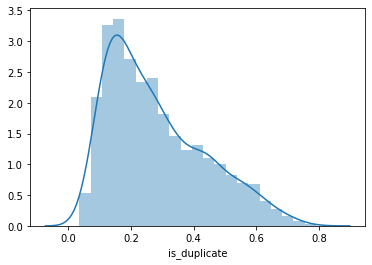

In [ ]:
sns.distplot(submission.is_duplicate[0:2000])

# Model 2 - LSTM (Neural Network)

#### Data Preprocessing

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(embedding_file_path, binary = True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



Found 3000000 word vectors of word2vec


In [ ]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

Convert word text to lists in Training dataset


In [ ]:
%%time

train_data_file = training_file_path
train_texts_1 = [] 
train_texts_2 = []
labels = []
with codecs.open(train_data_file, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)

    for values in reader:
        #print(values)
        train_texts_1.append(text_to_wordlist(values[3]))
        train_texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in train.csv' % len(train_texts_1))

Found 404290 texts in train.csv
CPU times: user 25.6 s, sys: 100 ms, total: 25.7 s
Wall time: 25.7 s


In [ ]:
# train_texts_1

# ['what is the step by step guide to invest in share market in india ',
#  'what is the story of kohinoor koh - i - noor diamond ',
#  'how can i increase the speed of my internet connection while using a vpn ', and many more]

In [ ]:
# train_texts_2

# ['what is the step by step guide to invest in share market ',
#  'what would happen if the indian government stole the kohinoor koh - i - noor diamond back ',
#  'how can internet speed be increased by hacking through dns ', ... and many more]

Convert word text to lists of Testing set.

In [ ]:
test_data_file = testing_file_path
test_texts_1 = []
test_texts_2 = []
test_ids = []

with codecs.open(test_data_file, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_texts_1.append(text_to_wordlist(values[1]))
        test_texts_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print('Found %s texts in test.csv' % len(test_texts_1))

Found 2345796 texts in test.csv


In [ ]:
# test_texts_1

# ['how does the surface pro himself 4 compare with ipad pro ',
#  'should i have a hair transplant at age 24 how much would it cost ',
#  'what but is the best way to send money from china to the us ',
#  'which food not emulsifiers ', ... and many more]

Tokenizer allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [ ]:
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(train_texts_1 + train_texts_2 + test_texts_1 + test_texts_2)

Convert Text data to Integers

In [ ]:
train_sequences_1 = tokenizer.texts_to_sequences(train_texts_1)
train_sequences_2 = tokenizer.texts_to_sequences(train_texts_2)

In [ ]:
# train_sequences_1

# [[2, 3, 1, 1254, 61, 1254, 2921, 8, 578, 7, 759, 370, 7, 35],
#  [2, 3, 1, 532, 10, 16563, 11914, 4, 22978, 4743],
#  [5, 13, 4, 293, 1, 423, 10, 18, 334, 1724, 153, 127, 6, 2885],
#  [15, 47, 4, 3396, 278, 3289, 5, 13, 4, 682, 17],
#  [23, 48, 5750, 7, 204, 55553, 1593, 2208, 10718, 12, 1892, 7839, 5204],
#  [2922, ... and many more ]]

In [ ]:
# train_sequences_2

# [[2, 3, 1, 1254, 61, 1254, 2921, 8, 578, 7, 759, 370],
#  [2, 45, 217, 24, 1, 87, 316, 12772, 1, 16563, 11914, 4, 22978, 4743, 193],
#  [5, 13, 334, 423, 28, 3425, 61, 1778, 220, 8301],
#  [82, 1, 4667, 37, 196, 2181, 1363, 196, 3, 2525, 61, 1363, 2181],
#  [23, 1574, 45, 1369, 7, 2208, 204], ... and many more]

In [ ]:
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 120499 unique tokens


In [ ]:
train_data_1 = pad_sequences(train_sequences_1, maxlen=30)
train_data_2 = pad_sequences(train_sequences_2, maxlen=30)
labels = np.array(labels)

print('Shape of data tensor:', train_data_1.shape)
print(labels)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=30)
test_data_2 = pad_sequences(test_sequences_2, maxlen=30)
test_ids = np.array(test_ids)

Shape of data tensor: (404290, 30)
[0 0 0 ... 0 0 0]
Shape of label tensor: (404290,)


In [ ]:
len(train_data_1)
# train_data_1

# array([[    0,     0,     0, ...,   370,     7,    35],
#        [    0,     0,     0, ...,     4, 22978,  4743],
#        [    0,     0,     0, ...,   127,     6,  2885],
#        ...,
#        [    0,     0,     0, ...,     3,    48,  3963],
#        [    0,     0,     0, ...,    32,    87,   214],
#        [    0,     0,     0, ...,   155,    27,  4447]], dtype=int32)

404290

#### Prepare Embeddings

In [ ]:
nb_words = min(200000, len(word_index))+1

embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)

In [ ]:
print(len(embedding_matrix))
print(len(embedding_matrix[0]))
# embedding_matrix

# array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
#          0.        ,  0.        ],
#        [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
#          0.04760742, -0.06884766],
#        [ 0.13964844, -0.00616455,  0.21484375, ...,  0.05712891,
#          0.09960938, -0.234375  ],
#        ...,
#        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
#          0.        ,  0.        ],
#        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
#          0.        ,  0.        ],
#        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
#          0.        ,  0.        ]])

120500
300


In [ ]:
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 61789


#### Split data


In [ ]:
VALIDATION_SPLIT = 0.1

perm = np.random.permutation(len(train_data_1))
idx_train = perm[:int(len(train_data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(train_data_1)*(1-VALIDATION_SPLIT)):]

In [ ]:
# len(idx_train)
# 363861

In [ ]:
# len(idx_val)
# 40429

In [ ]:
data_1_train = np.vstack((train_data_1[idx_train], train_data_2[idx_train]))
data_2_train = np.vstack((train_data_2[idx_train], train_data_1[idx_train]))

labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

In [ ]:
data_1_val = np.vstack((train_data_1[idx_val], train_data_2[idx_val]))
data_2_val = np.vstack((train_data_2[idx_val], train_data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))

re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

In [ ]:
# weight_val

# array([0.47200196, 0.47200196, 0.47200196, ..., 0.47200196, 0.47200196,
#        0.47200196])

#### Define Model

In [ ]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'


In [ ]:
print(num_lstm)
print(num_dense)
print(rate_drop_lstm)
print(rate_drop_dense)

In [ ]:
embedding_layer = Embedding(nb_words,
        300,
        weights=[embedding_matrix],
        input_length=30,
        trainable=False)

In [ ]:
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

In [ ]:
sequence_1_input = Input(shape=(30,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

In [ ]:
sequence_2_input = Input(shape=(30,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

In [ ]:
merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

Add Class weight


In [ ]:
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None


#### Train the Model

In [ ]:
model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)

model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])

model.summary()
# print(STAMP)

Adding Callbacks

In [ ]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'bst_model' + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [ ]:
hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

#### Test the Model

In [ ]:
preds = model.predict([test_data_1, test_data_2], batch_size=8192, verbose=1)
preds += model.predict([test_data_2, test_data_1], batch_size=8192, verbose=1)

preds /= 2

submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
#submission.to_csv('%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)

In [ ]:
submission